In [1]:
# TODO B delete some of these


import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import networkx as nx

import scipy
import csv

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import json
import community as community_louvain
from copy import deepcopy
# from modularity_maximization.utils import get_modularity

from itertools import product
import networkx.algorithms.community as nx_comm
from scipy.spatial.distance import pdist, squareform

from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame

import math
from time import time

import matplotlib.lines as lines

## %matplotlib inline
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data

In [2]:
# edgelists
mobility = pd.read_csv("../data/usageousers_city_mobility_CT_networks.rpt.gz")
follow_hh = pd.read_csv("../data/usageousers_city_follower_CT_HH_networks.rpt.gz")

cbsacode = pd.read_csv("../data/cbsacode_shortname_tracts.csv",sep=";", index_col=0)

# reading in the master dataset about graphs
tract_df = pd.read_csv('../data/network_properties.csv') ### PAY ATTENTION TRACT INSTEAD OF TRACTS!!!!
# new versionwithout two degrees - old: graph_properties

# reading geojson data, converting it to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# Cartesian coordinate projection of tract centroids
tract_geoms['centroid'] = tract_geoms['geometry'].centroid
tract_center_dict = tract_geoms\
    .set_geometry('centroid',crs={'init':'epsg:4326'})\
    .to_crs({'init':'epsg:3785'})\
    .set_index('full_geoid')['centroid'].map(lambda p: p.coords[0]).to_dict()

counties = gpd.read_file('../data/tl_2012_us_county.shp') # KERDES

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
# add city names to edgelists
cbsacode['city'] = cbsacode["short_name"].map(lambda s: s.split("/")[0].replace(' ','_').replace('.','').lower())
mobility = pd.merge(mobility, cbsacode[['geoid', 'city','short_name']], left_on = 'tract_home', right_on = 'geoid')
mobility = mobility.drop(columns = ['geoid'])
follow_hh = pd.merge(follow_hh, cbsacode[['geoid', 'city','short_name']], left_on = 'tract_home', right_on = 'geoid')
follow_hh = follow_hh.drop(columns = ['geoid'])
follow_hh = follow_hh.rename(columns={"tract_home.1": "tract_home_1"})

In [4]:
# adding normal city names
city_dict = dict(zip(cbsacode['city'],cbsacode['short_name']))
tract_df['short_name'] = tract_df['city'].map(city_dict)

In [5]:
# merge networks and coodrdinates

mobility = pd.merge(mobility,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home', right_on='full_geoid',how='left') # on home
mobility = mobility.drop(columns='full_geoid')
mobility = mobility.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

mobility = pd.merge(mobility,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_work', right_on='full_geoid',how='left') # on work
mobility = mobility.drop(columns='full_geoid')
mobility = mobility.rename(columns={"centroid": "centroid_work", "geometry": "polygon_work"})

follow_hh = pd.merge(follow_hh,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home', right_on='full_geoid',how='left') # on home_0
follow_hh = follow_hh.drop(columns='full_geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

follow_hh = pd.merge(follow_hh,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home_1', right_on='full_geoid',how='left') # on home_1
follow_hh = follow_hh.drop(columns='full_geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home_1", "geometry": "polygon_home_1"})

In [13]:
# colors

###colors_fol_hh_ms = ['#7f3b08','#b35806','#e08214','#fdb863','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b'

colors_fol_hh_mgn_1 = ['#7f3b08','#b35806','#e08214','#fdb863','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b'] # modified

# rearranged
colors_fol_hh_mgn = ['#7f3b08','#d9f0d3','#00441b','#b35806','#a6dba0','#e08214','#5aae61','#1b7837','#fdb863']


color_mob = '#2d004b'
color_mob_2 = '#8073ac'
color_fol_hh = '#00441b'
color_fol_hh_2 = '#5aae61'

# Functions

In [28]:
# Consensus community map drawer
def community_map(city, g_type, tract_df):
    """
    For a given network and algorithm used for calculating communities,
    it draws the colored community map eith tract boundaries.
    
    It uses the previously loaded `tract_geoms` GeoDataFrame in which geometrical data is stored,
    the `tract_df` pandas.DataFrames, in which consensus clustering labels are stored
    and colors_fol_hh_mgn color list.
    
    Parameters:
    -----------
    city : str
        name of the city, lowercase, '_' instead of ' '
        
    g_type : str
        either "mob" as mobility or "fol_hh" as follow_hh 
        selects the type of graph to return
        
    tract_df : pd.DataFrame
        contains community labels for each tract
        
    Returns:
    --------
    
    plot maps and save it to figures
        
    """
    
    # filter data to the given network's given communities
    map_df = deepcopy(tract_df[ (tract_df['city'] == city) & (tract_df['g_type'] == g_type)])
    # merge to geodata
    map_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], map_df, left_on='full_geoid', right_on='geoid')    
    
    ##colors = colors_fol_hh_ms if algorithm_type == 'ms' else colors_fol_hh_mgn if algorithm_type == 'mgn' else 0 # else is mandatory
    ##cmap = matplotlib.colors.ListedColormap(colors)
    
    # colormap - uses 9 colors <-- this is the number of communities in the network with most communities
    #cmap = matplotlib.colors.ListedColormap(['#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788'])
        
        ##['#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837']) lila - zold
        
        #['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'])
    
    
    f, ax = plt.subplots(1,2, figsize=(16,7))
    f.suptitle(city + ' '+ g_type, fontsize = 20)
    
    
    # Newman-Girwan
    ax[0].set_title('Girvan - Newman', size = 16)
    map_tracts_mgn = deepcopy(map_tracts[map_tracts['algorithm_type'] == 'mgn'])
    cmap = matplotlib.colors.ListedColormap(colors_fol_hh_mgn_1)
    map_tracts_mgn.plot(ax=ax[0], column = 'S_cons', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[0], color='black', linewidth=0.015)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax[0].set_axis_off()
    
    # Spatial a la Expert
    ax[1].set_title('Expert', size = 16)
    map_tracts_ms = deepcopy(map_tracts[map_tracts['algorithm_type'] == 'ms'])
    # SAME cmap = matplotlib.colors.ListedColormap(colors_fol_hh_ms)
    map_tracts_ms.plot(ax=ax[1], column = 'S_cons', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[1], color='black', linewidth=0.015)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax[1].set_axis_off()
    
    plt.show()

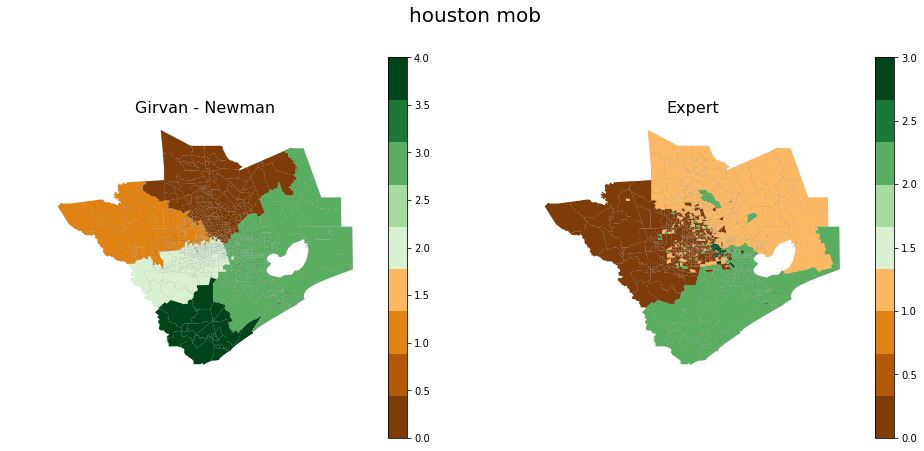

In [29]:
community_map('houston','mob', tract_df)

### Plot differences in clusterings

In [30]:
# Calculate the largers intersections of ms and mgn communities

# tract_df from long to wide based on algorithm_type
### KERDES EZ AZT CSINALJA, AMIT SZERETNÉK??
# pivot??

tract_wide_df = pd.pivot_table(tract_df, values='S_cons', index=['city','geoid', 'g_type'], columns=['algorithm_type']).reset_index()
tract_wide_df = tract_wide_df.rename_axis(None, axis=1) # delete the index name 'algorithm_type' remaining from the pivot table
#tract_wide_df = tract_wide_df.set_index('geoid')

In [31]:
tract_wide_df = tract_wide_df.rename(columns = {'mgn' : 'S_mgn', 'ms' : 'S_ms'})

In [32]:
# count how many tracts are in the intersections - how many tracts are labeled to S_mgn and S_ms
# ex: S_mgn = 0, S_ms = 1, count = 53, 53 tracts are both in community 0 based on Newman-Girwan community detection (and consensused)
## AND in community 1 based on Expert's community finding method (and consensused)
intersect_df = tract_wide_df.groupby(['city','g_type','S_mgn','S_ms']).count().reset_index()
intersect_df = intersect_df.rename(columns = {'geoid' : 'count'})

# for each S_mgn cluster get the S_ms clusters with which its intersection is the 'biggest' (based on number of intersection tracts stored in 'count')
most_intersect_df = intersect_df.groupby(['city','g_type','S_mgn'])[['count']].max().reset_index()
most_intersect_df = pd.merge(most_intersect_df, intersect_df, on = ['city', 'g_type', 'S_mgn', 'count'])
most_intersect_df['mgn>ms_intersect'] = 1

In [33]:
# other way ms --> mgn
intersect_2_df = tract_wide_df.groupby(['city','g_type','S_ms','S_mgn']).count().reset_index() # other way
intersect_2_df = intersect_2_df.rename(columns = {'geoid' : 'count'})
# for each S_ms cluster get the S_mgn clusters with which its intersection is the 'biggest' (based on number of intersection tracts stored in 'count')
most_intersect_2_df = intersect_2_df.groupby(['city','g_type','S_mgn'])[['count']].max().reset_index()
most_intersect_2_df = pd.merge(most_intersect_2_df, intersect_2_df, on = ['city', 'g_type', 'S_mgn', 'count'])
most_intersect_2_df['ms>mgn_intersect'] = 1

In [34]:
# add to overall dataset whether tract is in the "biggest intersection" either way (mgn --> ms or ms --> mgn)
# 1 -  yes, 0 - no
tract_wide_df = pd.merge(tract_wide_df,
                         most_intersect_df[['city','g_type', 'S_mgn', 'S_ms', 'mgn>ms_intersect']],
                         how = 'left',
                         on = ['city','g_type', 'S_mgn', 'S_ms'])

tract_wide_df = pd.merge(tract_wide_df,
                         most_intersect_2_df[['city','g_type', 'S_mgn', 'S_ms', 'ms>mgn_intersect']],
                         how = 'left',
                         on = ['city','g_type', 'S_mgn', 'S_ms'])

tract_wide_df = tract_wide_df.fillna(value = {'mgn>ms_intersect' : 0, 'ms>mgn_intersect' : 0})

In [48]:
# Consensus community map drawer
def community_map_2(city, g_type, tract_wide_df):
    """
    For a given network and algorithm used for calculating communities,
    it draws the colored community map and the map showing community intersections.
    (Pairing Girvan-Newman communities with Expert communities what is there intersection? 
    brown - not intersecting (pooled), light green - intersecting (pooled))
    
    It uses the previously loaded `tract_geoms` GeoDataFrame in which geometrical data is stored
    and `tract_wide_df` pandas.DataFrames, in which consensus clustering labels are stored
    and colors_fol_hh_mgn color list.
    
    Parameters:
    -----------
    city : str
        name of the city, lowercase, '_' instead of ' '
        
    g_type : str
        either "mob" as mobility or "fol_hh" as follow_hh 
        selects the type of graph to return
        
    tract_df : pd.DataFrame
        contains community labels for each tract
        
    Returns:
    --------
    
    plot maps and save it to figures
        
    """
    
    # filter data to the given network's given communities
    map_df = deepcopy(tract_wide_df[ (tract_wide_df['city'] == city) & (tract_wide_df['g_type'] == g_type)])
    S_mgn_max_label = map_df['S_mgn'].max() # the max is + 1 as indexed from 0
    S_ms_max_label = map_df['S_ms'].max() # the max is + 1 as indexed from 0
    
    print(S_mgn_max_label)
    print(S_ms_max_label)
    
    # merge to geodata
    map_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], map_df, left_on='full_geoid', right_on='geoid')
    
    
    f, ax = plt.subplots(2,2, figsize=(16,16))
    f.suptitle(city, fontsize = 20)
    
    # Newman-Girwan
    ax[0,0].set_title('Newman-Girwan', size = 16)
    cmap = matplotlib.colors.ListedColormap(colors_fol_hh_mgn[:S_mgn_max_label])
    map_tracts.plot(ax=ax[0,0], column = 'S_mgn', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[0,0], color='black', linewidth=0.015)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax[0,0].set_axis_off()
    
    # Spatial a la Expert
    ax[0,1].set_title('Expert', size = 16)
    cmap = matplotlib.colors.ListedColormap(colors_fol_hh_mgn[:S_ms_max_label])
    map_tracts.plot(ax=ax[0,1], column = 'S_ms', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[0,1], color='black', linewidth=0.015)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax[0,1].set_axis_off()
    
    # HOW TO READ: dark-green - not intersecting
    # biggest intersections of S_mgn with S_ms - pooled
    ax[1,0].set_title('intersections', size = 16)
    cmap_2 = matplotlib.colors.ListedColormap([colors_fol_hh_mgn[0], colors_fol_hh_mgn[1]])
    map_tracts.plot(ax=ax[1,0], column = 'mgn>ms_intersect', cmap = cmap_2, legend=True)
    map_tracts.centroid.plot(ax = ax[1,0], color='red', markersize=1)
    ax[1,0].set_axis_off()
    
    # biggest intersections of S_ms with S_mgn - pooled
    ax[1,1].set_title('intersections', size = 16)
    map_tracts = map_tracts.set_geometry('centroid')
    map_tracts.plot(ax=ax[1,1], column = 'ms>mgn_intersect', cmap = cmap_2, legend=True)
    ax[1,1].set_axis_off()
    
    plt.show()

In [49]:
tract_geoms.head()

,geometry,aland,awater,display_name,full_geoid,population,simple_name,sumlevel,centroid
0,"POLYGON ((-73.96209 40.96961, -73.95826 40.983...",4655526,11144,"Census Tract 70.02, Bergen, NJ",14000US34003007002,4751,Census Tract 70.02,140,POINT (-73.94853 40.97217)
1,"POLYGON ((-73.97598 40.95429, -73.97552 40.957...",5365613,19159,"Census Tract 91, Bergen, NJ",14000US34003009100,5007,Census Tract 91,140,POINT (-73.95678 40.95503)
2,"POLYGON ((-73.99830 40.80848, -73.99783 40.809...",736569,0,"Census Tract 63, Bergen, NJ",14000US34003006300,8013,Census Tract 63,140,POINT (-73.99132 40.81383)
3,"POLYGON ((-73.98915 40.90930, -73.98861 40.911...",2026199,5573,"Census Tract 152, Bergen, NJ",14000US34003015200,5922,Census Tract 152,140,POINT (-73.97673 40.90726)
4,"POLYGON ((-73.98486 40.87487, -73.98450 40.875...",3704990,21986,"Census Tract 155, Bergen, NJ",14000US34003015500,5854,Census Tract 155,140,POINT (-73.97056 40.87922)


4
5


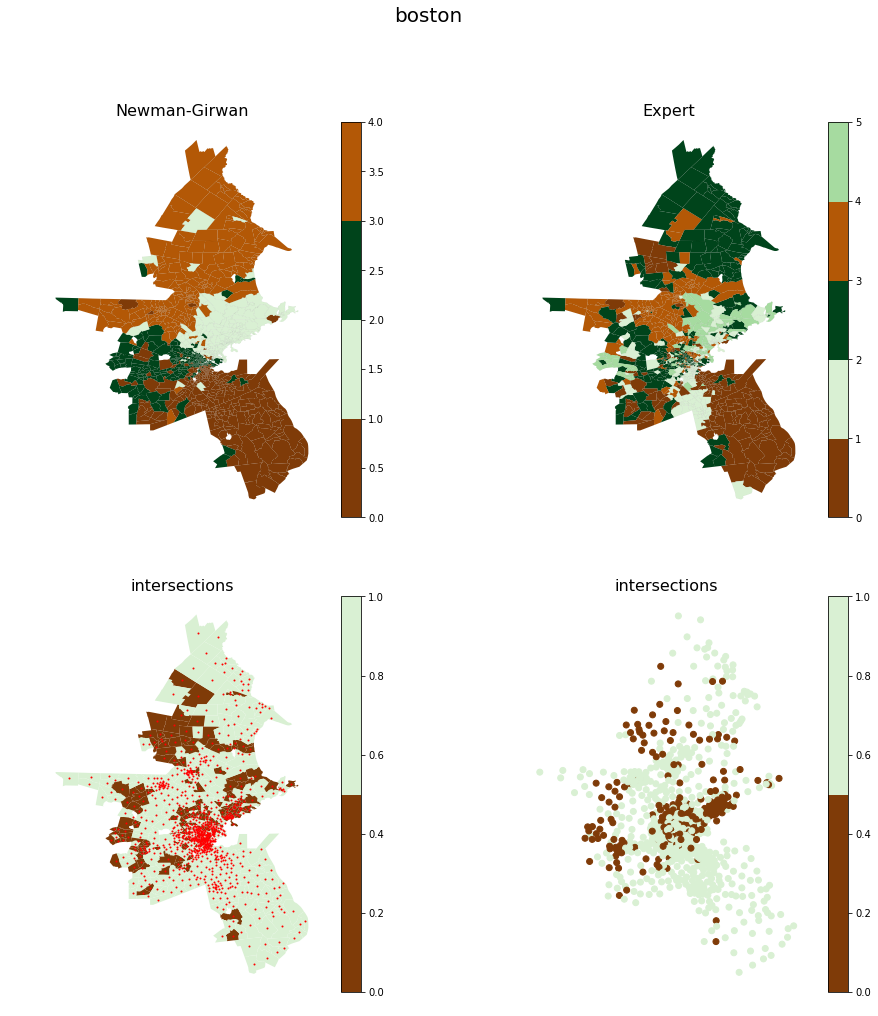

In [50]:
community_map_2('boston','fol_hh', tract_wide_df)

### Color the top 3 communities (based on the number of tracts in them)

In [51]:
# get the labels of the biggest (based on number of tracts) 3 S_mgn communities for each city
S_mgn_count_df = deepcopy(tract_wide_df.groupby(['city','g_type','S_mgn'])['geoid'].count().reset_index())
S_mgn_count_df = S_mgn_count_df.rename(columns = {'geoid' : 'count'})

biggest_3_S_mgn = deepcopy(S_mgn_count_df.sort_values(by=['city','g_type','count'], ascending=[True,True,False]).groupby(['city','g_type']).head(3))
biggest_3_S_mgn['top_3_S_mgn'] = 1

In [52]:
# add the S_ms-s with which the top 3 S_mgn-s intersects the most
# ~ add the corresponding S_ms-s
biggest_3_S_mgn = pd.merge(biggest_3_S_mgn, most_intersect_df[['city','g_type','S_mgn','S_ms']], how = 'left', on = ['city','g_type','S_mgn'])

tract_wide_df = pd.merge(tract_wide_df, biggest_3_S_mgn[['city','g_type','S_mgn','S_ms','top_3_S_mgn']], how = 'left', on = ['city','g_type','S_mgn'])

tract_wide_df = tract_wide_df.rename(columns = {'S_ms_x' : 'S_ms', 'S_ms_y' : 'S_ms_to_plot'})
# S_ms is the tracts label and S_ms_to_plot gives the label of the S_ms community with ehich the tract's S_mgn community intersects the most
# on the S_ms map those tracts should be colored for which S_ms == S_ms_to_plot

In [57]:
# Consensus community map drawer
def top_3_mgn_commun_and_inters(city, g_type, tract_wide_df):
    """
    Colors the top 3 (biggest) Newman-Girwan communities to a map and 
    those Expert type spatial communities which have the largest intersections with the top3 Newman-Girwan communities   
    """
    
    # filter data to the given network's given communities ATTENTION top 3 S_mgn-s filter later
    map_df = deepcopy(tract_wide_df[ (tract_wide_df['city'] == city) & (tract_wide_df['g_type'] == g_type)])
        
    # merge to geodata
    map_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], map_df, left_on='full_geoid', right_on='geoid')
   

    # create contour
    map_tracts_2 = deepcopy(map_tracts.set_geometry(map_tracts['geometry'])) ## KERDES: EZ JO MEGOLDAS ITT VAGY TUL SOK MEMORIA KELL ES MASHOGY KELLENE?
    map_tracts_2['buffered_tract'] = map_tracts_2.buffer(0.01)
    map_tracts_2 = map_tracts_2.set_geometry(map_tracts_2['buffered_tract']) 
    map_tracts_2['dissolve'] = 1
    city_boundary = map_tracts_2.dissolve(by = 'dissolve')
    
    # top 3 S_mgn-s filter
    map_tracts = map_tracts[map_tracts['top_3_S_mgn'] == 1]
   
    f, ax = plt.subplots(1,2, figsize=(16,8))
    f.suptitle(city + ' ' + g_type, fontsize = 20)
    
    # Newman-Girwan - top 3
    cmap = matplotlib.colors.ListedColormap(colors_fol_hh_mgn[:3])
    ax[0].set_title('Top 3 Newman-Girwan communities', size = 16)
    map_tracts.plot(ax=ax[0], column = 'S_mgn', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[0], color='black', linewidth=0.015)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    city_boundary.boundary.plot(ax = ax[0], color = 'black')
    f.delaxes(f.axes[2]) # remove colorbar
    ax[0].set_axis_off()
    
    # color the same way
    order = map_tracts.groupby(['S_mgn'])['S_ms_to_plot'].max() ### HIBA MIÉRT VAN TÖBB???
    color_dict = dict(zip(order,list(colors_fol_hh_mgn[:3])))
    
    # Spatial a la Expert - top 3 communities intersecting the above 3
    cmap = matplotlib.colors.ListedColormap([color_dict[x] for x in sort(list(order))])
    ax[1].set_title('Corresponding Expert communities', size = 16)
    map_tracts.boundary.plot(ax=ax[1], color='black', linewidth=0.015)
    # filter
    S_ms_to_plot_tracts = deepcopy(map_tracts[map_tracts['S_ms'] == map_tracts['S_ms_to_plot']])
    S_ms_to_plot_tracts.plot(ax=ax[1], column = 'S_ms', cmap=cmap, legend=True)
    city_boundary.boundary.plot(ax = ax[1], color = 'black')
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    f.delaxes(f.axes[2]) # remove colorbar - ax[3] became ax[2] when ax[2] was deleted
    ax[1].set_axis_off()
    
    plt.show()

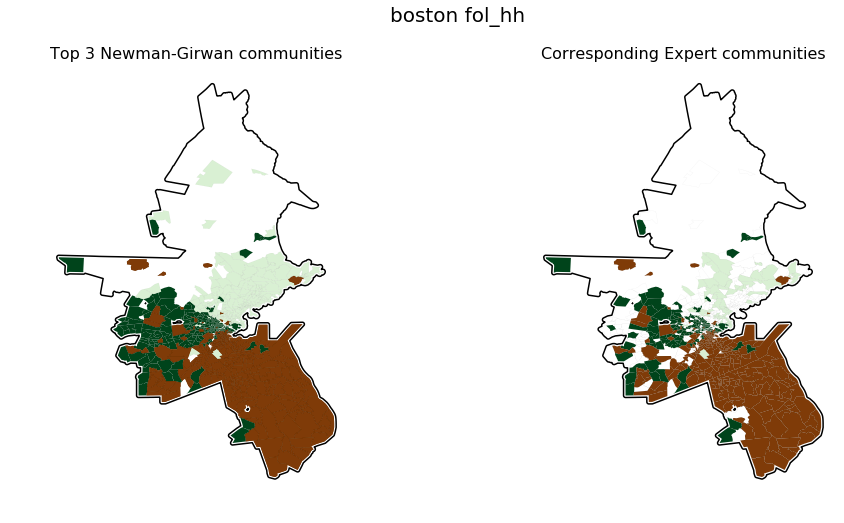

In [58]:
top_3_mgn_commun_and_inters('boston', 'fol_hh', tract_wide_df)

### Degree distribution

In [59]:
def degree_dist_histograms(city):
    
    """
    For a given city draws the degree distribution histograms.
    
    It uses the previously loaded `tract_df` pandas.DataFrame in which degree data is stored for each tract.
    
    Parameters:
    -----------
    city : str
        name of the city, in the form of cbsacode['short_name']
        ex: 'Salt Lake City'
        
    Returns:
    --------
    
    plot two histograms on eachother and save it to figures
        
    """
    
    plt.subplots(1,1,figsize=(8, 6))
    
    title = 'Degree distribution of tracts in ' + city
    plt.title(title, fontsize = 18)
    
    # data to plot
    degree_mob = tract_df[(tract_df['g_type'] == 'mob') & (tract_df['short_name'] == city)]['degree']
    degree_fol_hh = tract_df[(tract_df['g_type'] == 'fol_hh') & (tract_df['short_name'] == city)]['degree']

    #histogram
    bins = np.linspace(0, max(max(degree_mob), max(degree_fol_hh)), num = 50) # 50 bins 0 to max_degree
    mob , _ = np.histogram(degree_mob, bins=bins)
    fol_hh , _ = np.histogram(degree_fol_hh, bins=bins)
    
    # plot histogram
    plt.plot(bins[1:], mob, label = 'Mobility', marker='.', linewidth = 2, color = color_mob)
    plt.plot(bins[1:], fol_hh, label = 'Follower', marker='.', linewidth = 2, color = color_fol_hh)
    
    plt.xlabel('Degree', size = 16)
    plt.ylabel('No. tracts', size = 16)
    plt.legend(loc='upper right', fontsize = 14)
    plt.grid()
    plt.show()

    figname = 'degree_dist_' + city
    # savefig(figname, dpi=1200, bbox_inches='tight')

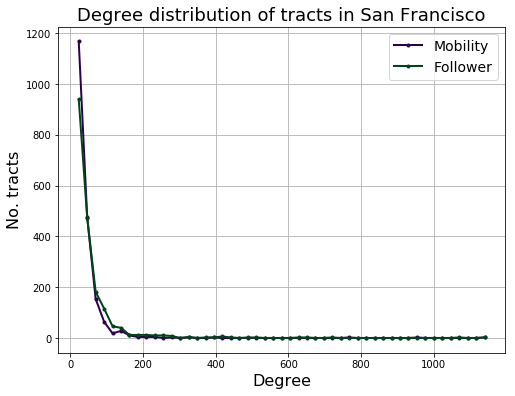

In [60]:
degree_dist_histograms('San Francisco')

# Bubble maps

In [61]:
# Create node weights for drawing the bubbles
# add up the weight from both sides of the edge

# Follower home-home
#set(follow_hh['tract_home']) - set(follow_hh['tract_home_1']) # empthy --> all the tracts which are home tracts a listed as tract_homes, so it is enoough to add up the weights for the one (of two) ways(s)

# check --> it was necessary as these are different
##set(follow_hh['cnt']*2 - follow_hh['all_home_cnt'])
fol_home_cnt_dict = dict(zip(follow_hh.tract_home,follow_hh.cnt))
fol_home_1_cnt_dict = dict(zip(follow_hh.tract_home_1,follow_hh.cnt))
all_home_cnt_dict = {k: fol_home_cnt_dict.get(k, 0) + fol_home_1_cnt_dict.get(k, 0) for k in set(fol_home_cnt_dict) | set(fol_home_1_cnt_dict)}
follow_hh['all_home_cnt'] = follow_hh['tract_home'].map(all_home_cnt_dict)



# Mobility # KERDES: Hogy lehet ezt egyszerubben?
mob_home_cnt_dict = dict(zip(mobility.tract_home,mobility.cnt))
mob_work_cnt_dict = dict(zip(mobility.tract_work,mobility.cnt))

mob_home_polygon_dict = dict(zip(mobility.tract_home,mobility.polygon_home))
mob_work_polygon_dict = dict(zip(mobility.tract_work,mobility.polygon_work))

# there are work tract that are not home tracts and vica versa
mob_cnt_dict = {k: mob_home_cnt_dict.get(k, 0) + mob_work_cnt_dict.get(k, 0) for k in set(mob_home_cnt_dict) | set(mob_work_cnt_dict)}

mob_cnt_df = pd.DataFrame.from_dict(mob_cnt_dict, orient='index').reset_index()
mob_cnt_df = mob_cnt_df.rename(columns = {'index' : 'geoid', 0 : 'cnt'})

mob_cnt_df['polygon'] = mob_cnt_df['geoid'].map(mob_home_polygon_dict)
mob_cnt_df['polygon_2'] = mob_cnt_df['geoid'].map(mob_work_polygon_dict)
mob_cnt_df['polygon'].fillna(mob_cnt_df['polygon_2'], inplace=True)
mob_cnt_df.drop(columns = 'polygon_2', inplace = True)

In [62]:
city_dict = dict(zip(cbsacode.geoid,cbsacode.city))
mob_cnt_df['city'] = mob_cnt_df.geoid.map(city_dict)

In [63]:
follow_hh['cnt'].max()

1330

In [64]:
# create edge lines
def line(x,y):
    return LineString([x,y])

In [77]:
def degree_bubble_map(city, mob_cnt_df, follow_hh):
    """
    For a given city draws the bubble networks on a map of 
    the mobility (communitng) and
    the socail ties (follower home-home).
    
    """
    
    # Create edge lines
    # geometry = edges between 
    # - home and work centroids
    # - homes of follower pairs tracts' centroids
    
    # filter for the city
    mob_cnt_df = deepcopy(mob_cnt_df[mob_cnt_df['city'] == city])
    follow_hh = deepcopy(follow_hh[follow_hh['city'] == city])
    
    # create contour
    follow_hh = follow_hh.set_geometry(follow_hh['polygon_home'])
    follow_hh['buffered_tract'] = follow_hh.buffer(0.01)
    follow_hh = follow_hh.set_geometry(follow_hh['buffered_tract'])
    follow_hh['dissolve'] = 1
    city_boundary = follow_hh.dissolve(by = 'dissolve')
    type(city_boundary)
  
    mob_cnt_df['geometry'] = mob_cnt_df.apply(lambda row: line(row['centroid_home'],row['centroid_work']), axis = 1) # KERDES MIERT KELL? ,axis=1)
    follow_hh['geometry'] = follow_hh.apply(lambda row: line(row['centroid_home'],row['centroid_home_1']), axis = 1) #,axis=1) 

    # convert into GeoDataFrame
    gdf_mobility= GeoDataFrame(mob_cnt_df, crs="EPSG:4326") # edges
    gdf_follow_hh = GeoDataFrame(follow_hh, crs="EPSG:4326")

    # GeoDataFrames for the bubbles
    gdf_mobility_nodes = gdf_mobility.set_geometry('centroid_work')
    gdf_follow_hh_nodes = gdf_follow_hh.set_geometry('centroid_home')

    
    # Draw figure
    f, ax = plt.subplots(1,2, figsize=(16,8))
    f.suptitle(city, fontsize = 20)
    
    # mobility
    ax[0].set_title('Commuting', size = 16)
    gdf_mobility.plot(ax = ax[0], linewidth=gdf_mobility['cnt']*0.05, color = color_mob) # edges
    gdf_mobility_nodes.plot(ax = ax[0], alpha=0.5, markersize=gdf_mobility_nodes['cnt']*2, color='black')
    city_boundary.boundary.plot(ax = ax[0], color = 'black')
    ax[0].set_axis_off()

    # fol_hh
    ax[1].set_title('Social ties', size = 16)
    gdf_follow_hh.plot(ax = ax[1], alpha = 0.7, linewidth = gdf_follow_hh['cnt']*0.01, color = color_fol_hh)  #'#33a02c')#'#01665e')#'#1b7837')#'#542788')# #########'#762a83')# #    
    gdf_follow_hh_nodes.plot(ax = ax[1], alpha=0.2, markersize = gdf_follow_hh_nodes['all_home_cnt'].astype('float')*2, color='black')
    city_boundary.boundary.plot(ax = ax[1])
    ax[1].set_axis_off()
    
    plt.show()
    filename = 'network_bubble_map_' + city
    # savefig(filename, dpi=1200, bbox_inches='tight')

    # TODO CHECK AND CORRECT SIZES

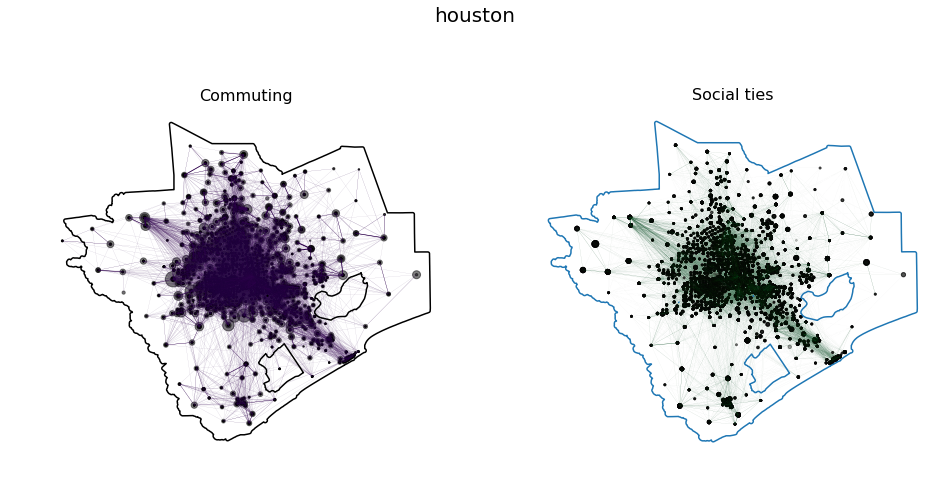

In [78]:
degree_bubble_map('houston', mobility, follow_hh)

# Aggregate plots

In [98]:
# Aggregate dataframe for sorting boxplot drawing

# by network
network_df = tract_df.groupby(['short_name','g_type'])['short_name','g_type','density', 'population_1_city_sum'].mean().reset_index()

# by community
community_df = tract_df.groupby(['short_name', 'g_type', 'algorithm_type', 'S_cons']).mean() # KERDES EZ MMIERT MUKODIK??

In [99]:
# sort by total population
network_df = network_df.sort_values(by=['population_1_city_sum'])

In [100]:
def sorting(df_grouped, by):
    sorted_parts = list(df_grouped.sort_values(by = by, ascending = False).index)
    return sorted_parts

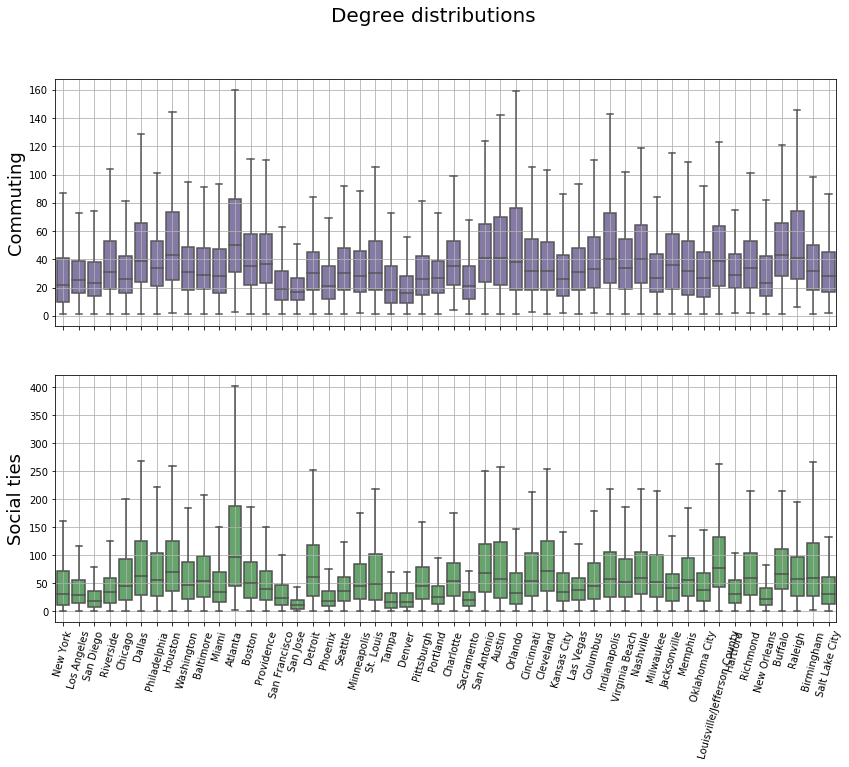

In [106]:
# JAVITANI - rendezes
fig,ax=plt.subplots(2,1, sharex=True, figsize=(14,10))
fig.suptitle('Degree distributions', fontsize=20)

x = 'short_name' # city
y = 'degree'

###sorted_parts_mob = sorting(tract_df[tract_df['g_type'] == 'mob'], tract_df['population_1_city_sum'])
###sorted_parts_fol_hh = sorting(community_df[community_df['g_type'] == 'fol_hh'], y)

sns.boxplot(ax = ax[0], x = x, y = y, data = tract_df[tract_df['g_type'] == 'mob'], color = color_mob_2, showfliers = False) #, order = sorted_parts_mob)#.set_xticklabels(labels = tract_df[tract_df['g_type'] == 'mob']['city'], rotation=30) #, order = sorted_parts) #KERDES - UGYANAZOK A SZINEK
# ax[0].set_title('Mobility')
ax[0].set_xlabel('')
#ax[0].set_ylim(0,200)
ax[0].set_ylabel('Commuting', size = 18)
city_l = list(tract_df[tract_df['g_type'] == 'mob']['short_name'].unique()) # KERDES EZT HASZNALHATOM??????
ax[0].set_xticklabels(city_l, rotation = 75)
ax[0].grid()

sns.boxplot(ax = ax[1], x = x, y = y, data = tract_df[tract_df['g_type'] == 'fol_hh'], color = color_fol_hh_2, showfliers = False) #, order = sorted_parts_lw)
#ax[1].set_title('Follower home-home')
ax[1].set_xlabel('')
#ax[1].set_ylim(0,200)
ax[1].set_ylabel('Social ties', size = 18)
city_l = list(tract_df[tract_df['g_type'] == 'fol_hh']['short_name'].unique()) # KERDES EZT HASZNALHATOM??????
ax[1].set_xticklabels(city_l, rotation = 75)
ax[1].grid()

In [109]:
a = network_df[network_df['g_type'] == 'mob']['density']
b = network_df[network_df['g_type'] == 'fol_hh']['density']
min_dens = [min(i) for i in zip(a, b)]
max_dens = [max(i) for i in zip(a, b)]

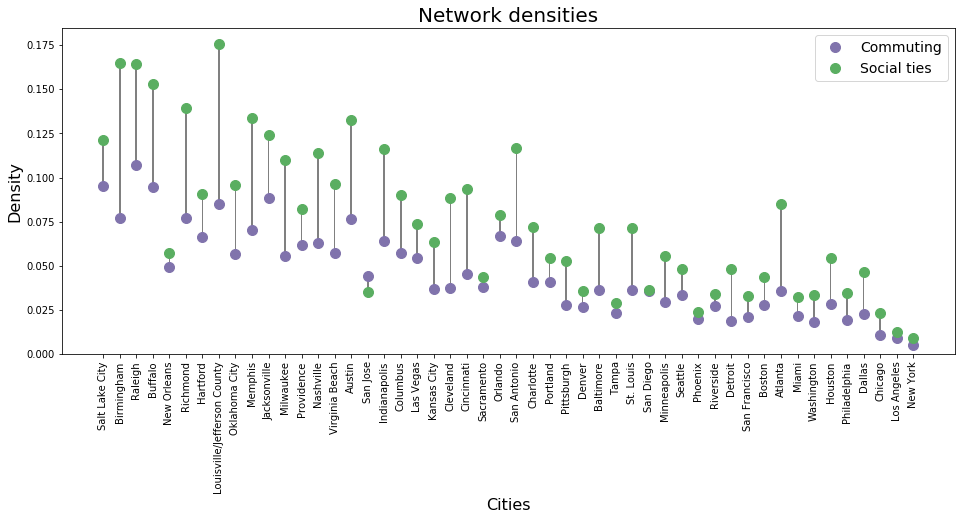

In [127]:
plt.subplots(figsize=(16, 6))

ind = network_df[network_df['g_type'] == 'mob']['short_name']
plt.plot(ind, network_df[network_df['g_type'] == 'mob']['density'], label = 'Commuting', marker='o', linewidth = 0, markersize = 10, color = color_mob_2)
plt.plot(ind, network_df[network_df['g_type'] == 'fol_hh']['density'], label = 'Social ties', marker='o', linewidth = 0, markersize = 10, color = color_fol_hh_2)
plt.bar(ind, max_dens, 0.1, color = 'grey')
plt.bar(ind, min_dens, 0.1, color = 'white')


plt.xlabel('Cities', size = 16)
plt.ylabel('Density', size = 16)
plt.legend(loc='upper right', fontsize = 14)
plt.xticks(network_df[network_df['g_type'] == 'mob']['short_name'], rotation = 90) # same order in fol_hh
plt.title('Network densities', size = 20)
plt.show()

## Size of communities by methods

In [111]:
# get the number of communities for all cities and both algorithm types
S_max_list_ms = []
S_max_list_mgn = []
for city in city_l:
    S_max_list_ms.append(tract_df[(tract_df['short_name'] == city) & (tract_df['algorithm_type'] == 'ms')]['S_cons'].max()+1)
    S_max_list_mgn.append(tract_df[(tract_df['short_name'] == city) & (tract_df['algorithm_type'] == 'mgn')]['S_cons'].max()+1)

#### Bubble chart - same as above but bubble size equals frequency

In [113]:
# calculate the frequency of having X clusters using the Girvan-Newman method and Y using Expert's method
S_max_df = pd.DataFrame()
S_max_df['city'] = city_l
S_max_df['ms'] = S_max_list_ms
S_max_df['mgn'] = S_max_list_mgn
S_max_to_plot = S_max_df.groupby(['ms','mgn']).count().reset_index()
S_max_to_plot = S_max_to_plot.rename(columns = {'city' : 'count'})

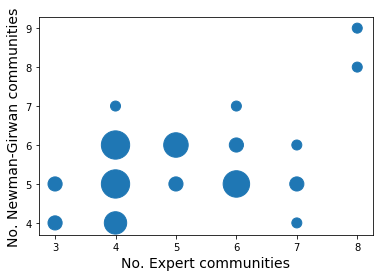

In [118]:
plt.scatter(S_max_to_plot['ms'],
            S_max_to_plot['mgn'],
            s = S_max_to_plot['count']*100)
plt.xlabel('No. Expert communities', size = 14)
plt.ylabel('No. Newman-Girwan communities', size = 14)
plt.show()

# depreciated

In [31]:
city = 'boston' # should be a clean name - all lowercase, containing '_' instead of ' '

In [32]:
city_mob_ms_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'mob') & (df['algorithm_type'] == 'ms')])
city_mob_mgn_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'mob') & (df['algorithm_type'] == 'mgn')])
city_fol_hh_ms_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'fol_hh') & (df['algorithm_type'] == 'ms')])
city_fol_hh_mgn_df = deepcopy(df[ (df['city'] == city) & (df['g_type'] == 'fol_hh') & (df['algorithm_type'] == 'mgn')])

In [33]:
city_mob_ms_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_mob_ms_df, left_on='full_geoid', right_on='geoid')
city_mob_mgn_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_mob_mgn_df, left_on='full_geoid', right_on='geoid')
city_fol_hh_ms_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_fol_hh_ms_df, left_on='full_geoid', right_on='geoid')
city_fol_hh_mgn_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], city_fol_hh_mgn_df, left_on='full_geoid', right_on='geoid')

city_mob_ms_tracts = city_mob_ms_tracts.drop(columns='full_geoid')
city_mob_mgn_tracts = city_mob_mgn_tracts.drop(columns='full_geoid')
city_fol_hh_ms_tracts = city_fol_hh_ms_tracts.drop(columns='full_geoid')
city_fol_hh_mgn_tracts = city_fol_hh_mgn_tracts.drop(columns='full_geoid')

In [43]:
max(df.S_cons) # --> 9 colors in colormap 

8

### Consensus communities on maps

In [55]:
# uses 9 colors <-- this is the number of communities in the network with most communities
cmap = matplotlib.colors.ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999'])

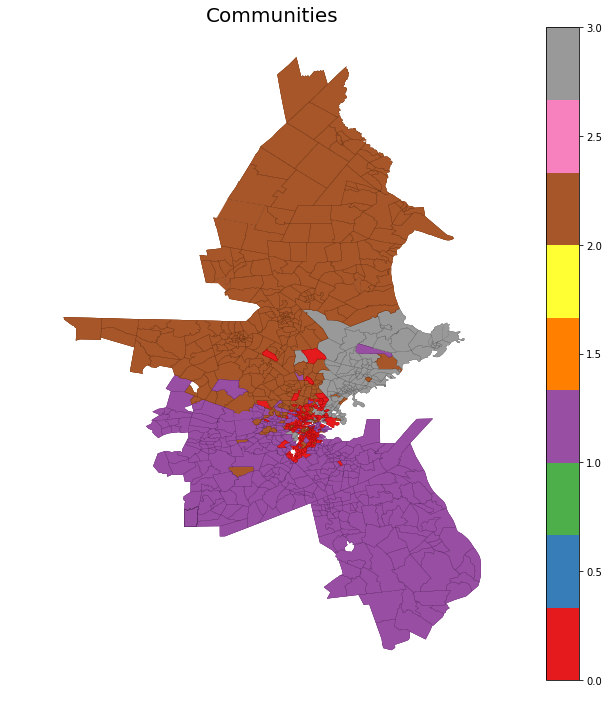

In [56]:
# g_type : mobility
# algorthm_type : Expert

f, ax = plt.subplots(1, figsize=(16,12))
city_mob_ms_tracts.plot(ax=ax, column = 'S_cons', cmap=cmap, legend=True)
city_mob_ms_tracts.boundary.plot(ax=ax, color='black', linewidth=0.015)
#city_mob_mgn_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
ax.set_axis_off()
plt.title('Communities', size=20)
plt.show()

# savefig('consen_communities_mob_ms', dpi=1200, bbox_inches='tight')

In [ ]:
gdf_mobility = GeoDataFrame(mobility, crs="EPSG:4326")
gdf_follow_ww = GeoDataFrame(follow_ww, crs="EPSG:4326")
gdf_follow_hh = GeoDataFrame(follow_hh, crs="EPSG:4326")

In [ ]:
gdf_mobility_home = gdf_mobility.set_geometry('centroid_home')
gdf_mobility_work = gdf_mobility.set_geometry('centroid_work')

In [ ]:
# térképes, pöttyös

f, ax = plt.subplots(1, figsize=(32,16))
boston_tracts_all.boundary.plot(ax=ax)
gdf_mobility.plot(ax=ax, alpha=0.1, linewidth=gdf_mobility['cnt']*0.3, color='black')
gdf_mobility_home.plot(ax=ax, alpha=0.2, markersize=gdf_mobility_home['cnt']*3, color='blue')
gdf_mobility_work.plot(ax=ax, alpha=0.2, markersize=gdf_mobility_work['cnt']*3, color='yellow')
ax.set_axis_off()
plt.show()